# Final Project
DS 2500 - Data Wrangling
Richard Timpson

For the final project I would like to further explore forecasting for both home energy consumption and photovaltaic solar energy production. I have previously built two different models for each problem that used different methods for forecasting. For PV production I used a standard ordinary least squares regression using weather and solar irradiance to predict energy production. For the home energy consumption I used a basic autoregressive model to forecast further home consumption. 

In this notebook and project, I am going to combine both of these methods into one to create two separate models that use a combination of time-series forecasting methods with other standard regression methods using other data as explantory variables. Because the PV production data is time-series data, I would like to simply add that type of analysis into the existing model. For the home consumption data I want to add other explantory variables. Right now my plan is to add weather variables to see how it affects the model, but there is other data that I am going to collect if I can such as the size of the house and information about the appliances. 

## PV Energy Forecasting
To start out, I am going to build on work that I have done in another class that relates to a linear regressive model for PV forecasting. This model uses weather and solar irradiance as explantory variables, but does not consider the auto correlations in the data. This will require some feature engineering to add the lags into the existing data. It should be as simple as adding the lags with the other variables and seeing how this affects the regressive model. 

In [21]:
import train_test_split
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

DATA_DIR = '../../../data'

Read in relevant PV site metadata

In [6]:
import json

with open(f'{DATA_DIR}/production_data/site_metadata_anon.json', 'r') as file:
    s = file.read()
    site_md = json.loads(s)

## Data and Feature Engineering
Read in all of the data sets. This code was used from another project so it is getting the data as numpy vectors rather than pandas data frames. I will be putting it in a dataframe later. I am getting a train test split on the data set by sampling from the data over a 4 day window and choosing 75% of the values from these 4 days for the train, adn 25% of the values for the test set. This gurantees that all seasons will be represented in the data equally and that the model evaluation should be more reliable. 

### Feature Engineering methods

In [127]:
from sklearn.model_selection import TimeSeriesSplit

def set_irr_df_dt(df, tz):
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df = df.set_index('date')
    df = df.resample('1H').mean()
    df.index = df.index.tz_localize(tz, nonexistent='NaT', ambiguous='NaT')
    return df 

def set_prod_df_dt(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df 

def read_weather_irr_df(site):
    site_id = site['id']
    timezone = site['location']['timeZone']
    irradiance_id = site['irradiance_site_id']
    production_path = f'{DATA_DIR}/production_data/{site_id}/combination_data/production_weather_combination.csv'
    irradiance_path = f'{DATA_DIR}/irradiance_data/{irradiance_id}/irradiance_data.csv'

    prod_df = pd.read_csv(production_path)
    prod_df = set_prod_df_dt(prod_df)
    irr_df = pd.read_csv(irradiance_path)
    irr_df = set_irr_df_dt(irr_df, timezone)

    return prod_df, irr_df

def combine_weather_df(irr_df, prod_df):
    df = irr_df.merge(prod_df, how='inner', left_index=True, right_index=True)

    # It's important to note that the resulting datetime index will be in UTC after the merge 
    return df


def clean_df(df):
    df = df.dropna(subset=['production'])
    df = df[df['production'] != 0]
    return df 

def add_lags(df, num_lags):
    for i in range(num_lags):
        df[f'production_lag_{i+1}'] = df['production'].shift(i+1)
    return df 

def get_final_df(site, num_lags): 
    prod_df, irr_df = read_weather_irr_df(site)
    df = combine_weather_df(irr_df, prod_df)
    df = clean_df(df)
    df = add_lags(df, num_lags)
    return df 

def train_test_splits(df):
    num_splits = 3
    s = TimeSeriesSplit(num_splits)
    df = df.reset_index()
    splits = []
    for train_index, test_index in s.split(df):
        print(train_index, test_index)        
        test, train = df.iloc[train_index], df.iloc[test_index]
        splits.append((test, train))
    return splits 

In [179]:
num_lags = 10

site = site_md[0]
df = get_final_df(site, num_lags)
print(df.columns)
df 

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DHI',
       'DNI', 'Wind Speed', 'Temperature', 'Solar Zenith Angle',
       'precipIntensity', 'precipProbability', 'precipAccumulation',
       'precipType', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'pressure', 'windSpeed', 'windBearing', 'windGust',
       'cloudCover', 'uvIndex', 'visibility', 'ozone', 'production',
       'production_lag_1', 'production_lag_2', 'production_lag_3',
       'production_lag_4', 'production_lag_5', 'production_lag_6',
       'production_lag_7', 'production_lag_8', 'production_lag_9',
       'production_lag_10'],
      dtype='object')


Unnamed: 0    Year  Month   Day  Hour  Minute  \
date                                                                       
2015-02-09 21:00:00+00:00      1900.5  2015.0    2.0   9.0  14.0    15.0   
2015-02-09 22:00:00+00:00      1902.5  2015.0    2.0   9.0  15.0    15.0   
2015-02-09 23:00:00+00:00      1904.5  2015.0    2.0   9.0  16.0    15.0   
2015-02-10 00:00:00+00:00      1906.5  2015.0    2.0   9.0  17.0    15.0   
2015-02-10 01:00:00+00:00      1908.5  2015.0    2.0   9.0  18.0    15.0   
...                               ...     ...    ...   ...   ...     ...   
2018-12-31 20:00:00+00:00     17498.5  2018.0   12.0  31.0  13.0    15.0   
2018-12-31 21:00:00+00:00     17500.5  2018.0   12.0  31.0  14.0    15.0   
2018-12-31 22:00:00+00:00     17502.5  2018.0   12.0  31.0  15.0    15.0   
2018-12-31 23:00:00+00:00     17504.5  2018.0   12.0  31.0  16.0    15.0   
2019-01-01 00:00:00+00:00     17506.5  2018.0   12.0  31.0  17.0    15.0   

                             GHI    DHI    DNI  Wind Speed  ...  \
date                                                        ...   
2015-02-09 21:00:00+00:00    0.0    0.0    0.0        1.45  ...   
2015-02-09 22:00:00+00:00  118.5   30.5  598.5        1.90  ...   
2015-02-09 23:00:00+00:00  313.5   48.0  838.5        3.10  ...   
2015-02-10 00:00:00+00:00  486.5   56.5  937.5        4.80  ...   
2015-02-10 01:00:00+00:00  613.0   61.5  984.5        5.50  ...   
...                          ...    ...    ...         ...  ...   
2018-12-31 20:00:00+00:00    0.0    0.0    0.0        1.25  ...   
2018-12-31 21:00:00+00:00    0.0    0.0    0.0        1.60  ...   
2018-12-31 22:00:00+00:00   63.5   25.0  385.0        2.85  ...   
2018-12-31 23:00:00+00:00  201.5   59.5  615.5        4.20  ...   
2019-01-01 00:00:00+00:00  263.5  107.0  413.5        4.85  ...   

                           production_lag_1  production_lag_2  \
date                                                            
2015-02-09 21:00:00+00:00               NaN               NaN   
2015-02-09 22:00:00+00:00         1813.9670               NaN   
2015-02-09 23:00:00+00:00         1582.5759         1813.9670   
2015-02-10 00:00:00+00:00         1198.3170         1582.5759   
2015-02-10 01:00:00+00:00          627.7450         1198.3170   
...                                     ...               ...   
2018-12-31 20:00:00+00:00          910.0000          334.0000   
2018-12-31 21:00:00+00:00         1549.0000          910.0000   
2018-12-31 22:00:00+00:00         1474.0000         1549.0000   
2018-12-31 23:00:00+00:00          158.0000         1474.0000   
2019-01-01 00:00:00+00:00          475.0000          158.0000   

                           production_lag_3  production_lag_4  \
date                                                            
2015-02-09 21:00:00+00:00               NaN               NaN   
2015-02-09 22:00:00+00:00               NaN               NaN   
2015-02-09 23:00:00+00:00               NaN               NaN   
2015-02-10 00:00:00+00:00         1813.9670               NaN   
2015-02-10 01:00:00+00:00         1582.5759          1813.967   
...                                     ...               ...   
2018-12-31 20:00:00+00:00          443.0000           236.000   
2018-12-31 21:00:00+00:00          334.0000           443.000   
2018-12-31 22:00:00+00:00          910.0000           334.000   
2018-12-31 23:00:00+00:00         1549.0000           910.000   
2019-01-01 00:00:00+00:00         1474.0000          1549.000   

                           production_lag_5 production_lag_6  \
date                                                           
2015-02-09 21:00:00+00:00               NaN              NaN   
2015-02-09 22:00:00+00:00               NaN              NaN   
2015-02-09 23:00:00+00:00               NaN              NaN   
2015-02-10 00:00:00+00:00               NaN              NaN   
2015-02-10 01:00:00+00:00               NaN              NaN   
...                       

In [172]:
dfs = {}
for site in site_md:
    try:
        df = get_final_df(site, num_lags)
    except FileNotFoundError:
        print(f'Skipping site {site["id"]}. No irradiance data ')
    dfs[site['id']] = df

Skipping site 1232644. No irradiance data 


### Plot Methods

In [204]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sb 

def plot_ac(df, lags, site_id):
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(19,5))
    ax = pd.plotting.autocorrelation_plot(df['production'], axes[0])
    ax.set_xlim((0, lags))
    # sm.graphics.tsa.plot_acf(df['production'], zero=False, lags=lags, ax=axes[0], alpha=0.5)
    sm.graphics.tsa.plot_pacf(df['production'], zero=False, lags=lags, ax=axes[1], alpha=0.5)
    axes[0].set_title(f'Autocorrelation for system {site_id}')
    axes[1].set_title(f'Partial autocorrelation for system {site_id}')


def plot_heat(df, site_id, cols):
    df_corr = df[cols].corr()

    # Using masking code from: https://seaborn.pydata.org/generated/seaborn.heatmap.html
    df_mask = np.zeros_like(df_corr)
    df_mask[np.triu_indices_from(df_mask)] = True

    # Set up the plotting environment
    f,ax = plt.subplots(1,1,figsize=(17,10))

    # Make a heatmap
    sb.heatmap(df_corr,vmin=0,vmax=1,mask=df_mask,annot=True,square=True,ax=ax,cmap='coolwarm_r')

    # f.tight_layout()

def plot_ac_heat(df, lags, site_id):
    cols = ['production'] + [f'production_lag_{i + 1}' for i in range(lags)]
    plot_heat(df, site_id, cols)

# Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DHI',
#        'DNI', 'Wind Speed', 'Temperature', 'Solar Zenith Angle',
#        'precipIntensity', 'precipProbability', 'precipAccumulation',
#        'precipType', 'temperature', 'apparentTemperature', 'dewPoint',
#        'humidity', 'pressure', 'windSpeed', 'windBearing', 'windGust',
#        'cloudCover', 'uvIndex', 'visibility', 'ozone', 'production',
#        'production_lag_1', 'production_lag_2', 'production_lag_3',
#        'production_lag_4', 'production_lag_5', 'production_lag_6',
#        'production_lag_7', 'production_lag_8', 'production_lag_9',
#        'production_lag_10'],
#       dtype='object')
def plot_weather_heat(df, lags, site_id):
    cols = [
        'precipIntensity', 
        'precipProbability', 
        'precipAccumulation', 
        'precipType', 
        'temperature', 
        'apparentTemperature', 
        'dewPoint', 
        'humidity', 
        'pressure', 
        'windSpeed', 
        'windBearing', 
        'windGust', 
        'cloudCover', 
        'uvIndex', 
        'visibility', 
        'ozone', 
        'production'
    ]
    plot_heat(df, site_id, cols)

def plot_irr_heat(df, lags, site_id):
    cols = [
        'GHI', 
        'DHI', 
        'DNI', 
        'production'
    ]
    plot_heat(df, site_id, cols)

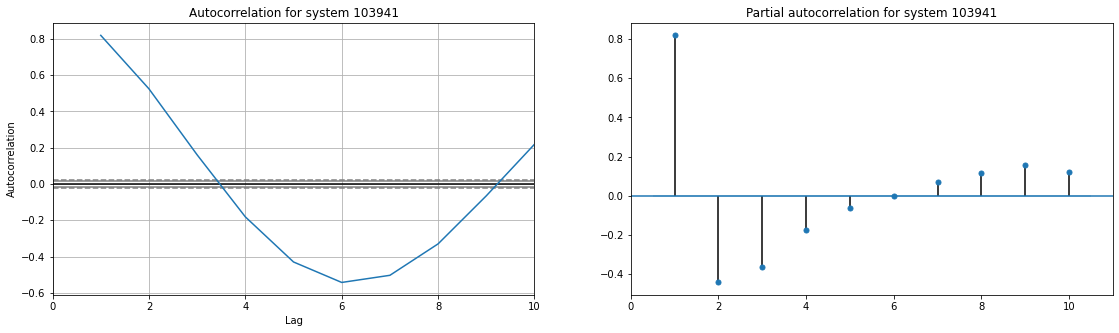

In [198]:
plot_ac(dfs[103941], 10, 103941)

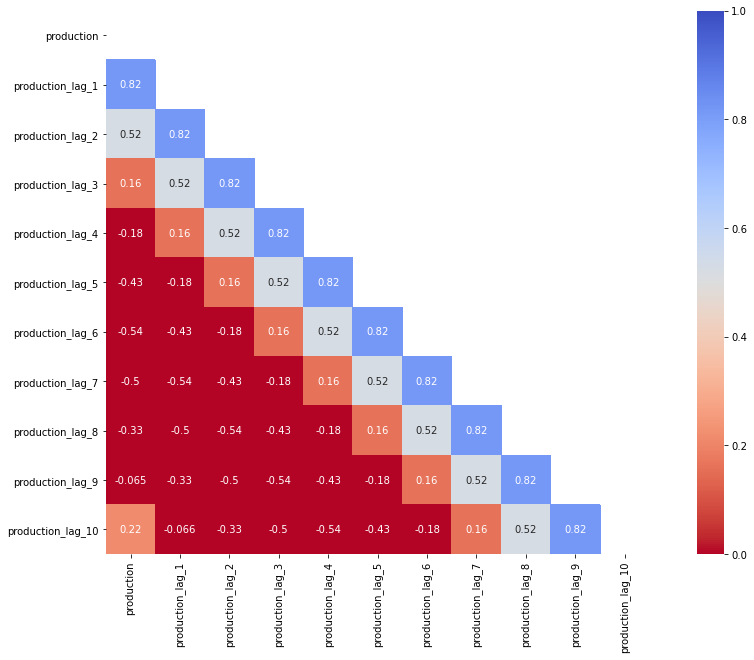

In [199]:
plot_ac_heat(dfs[103941], num_lags, 103941)

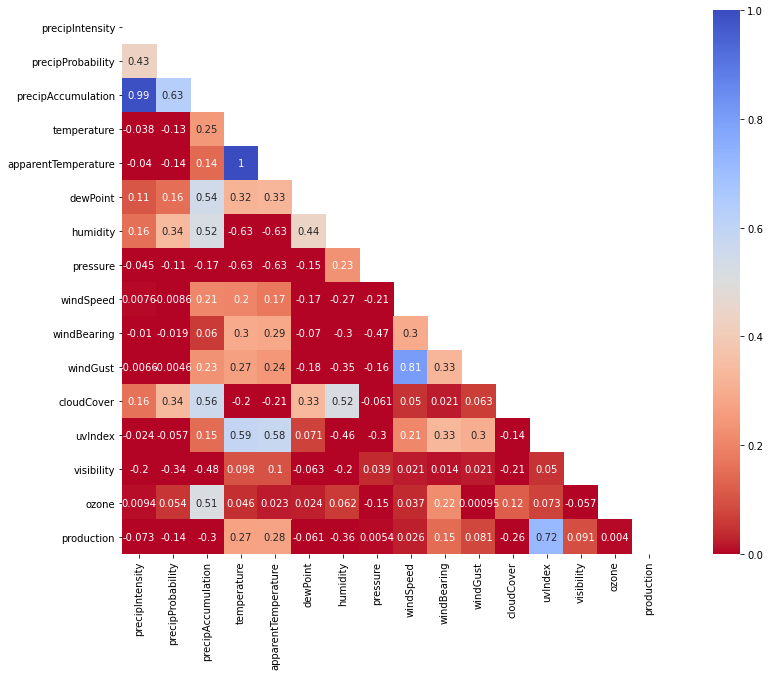

In [200]:
plot_weather_heat(dfs[103941], num_lags, 103941)

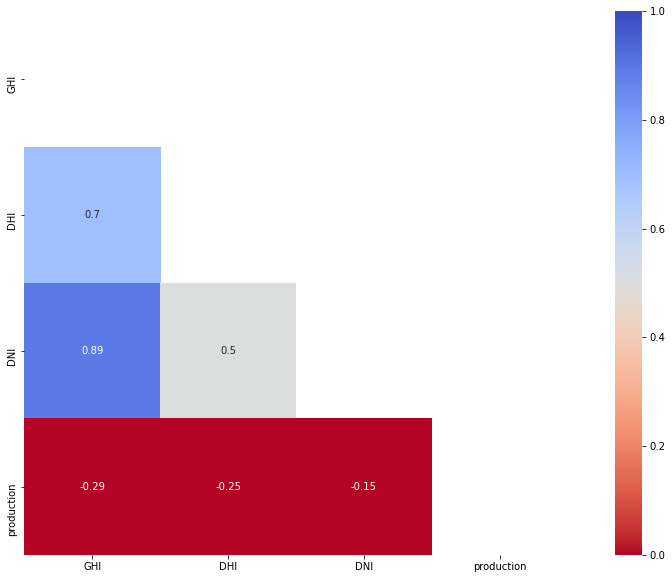

In [205]:
plot_irr_heat(dfs[103941], num_lags, 103941)

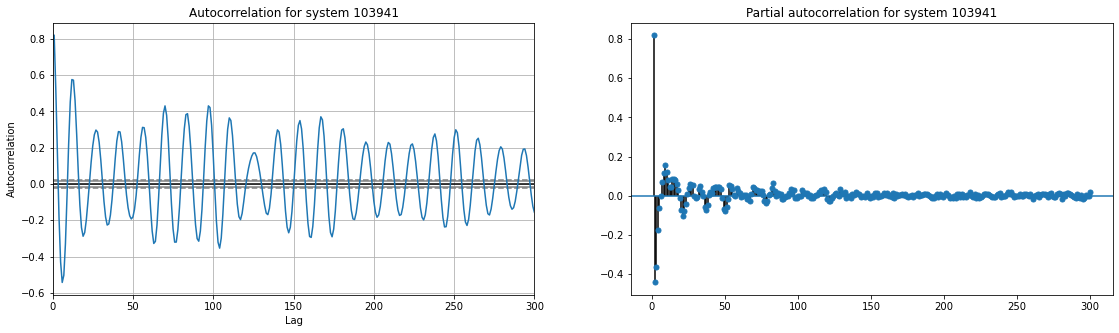

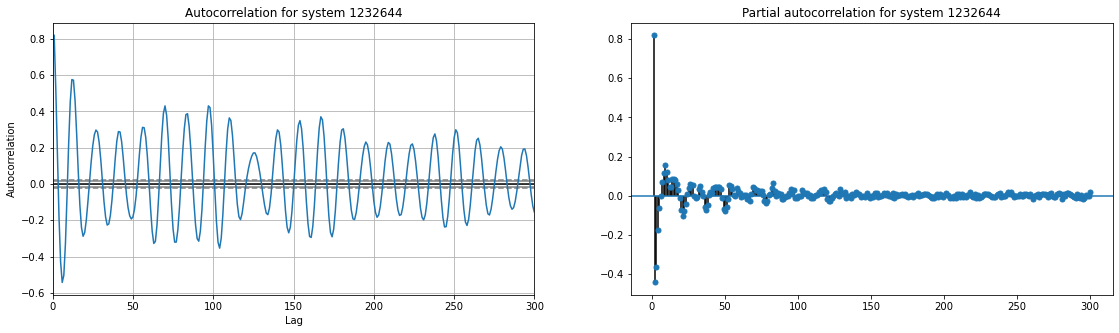

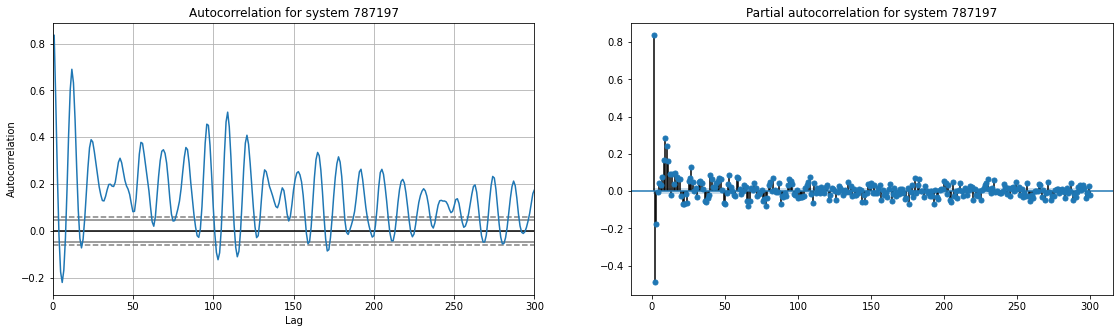

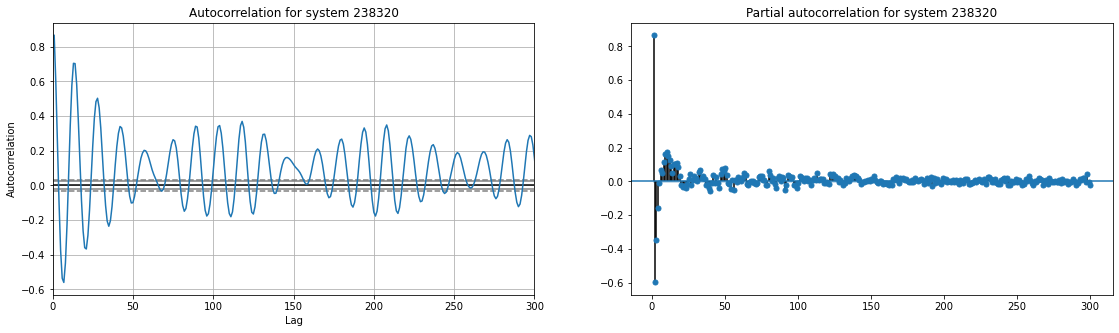

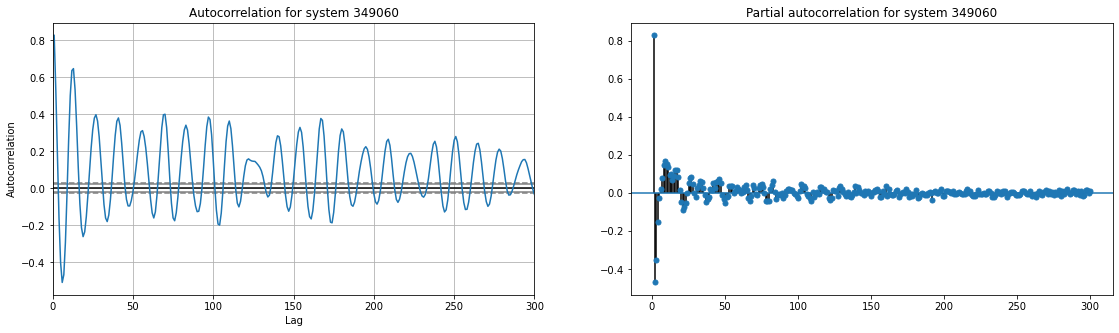

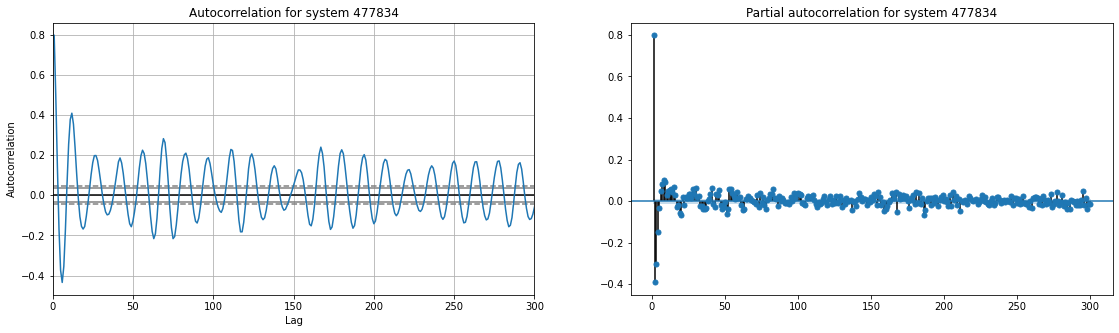

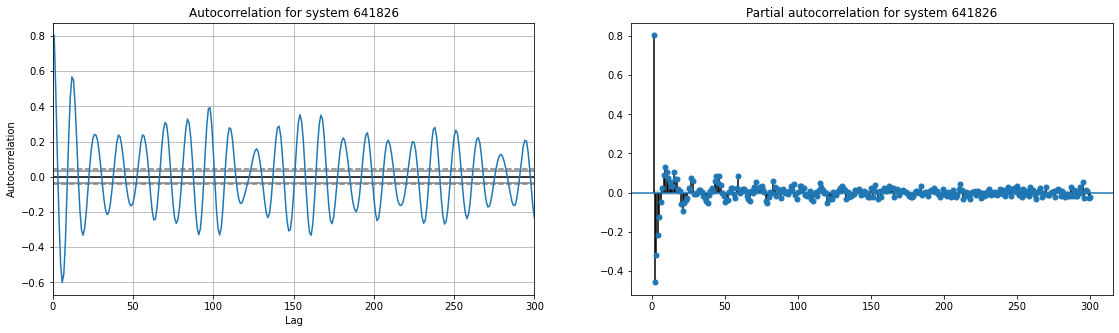

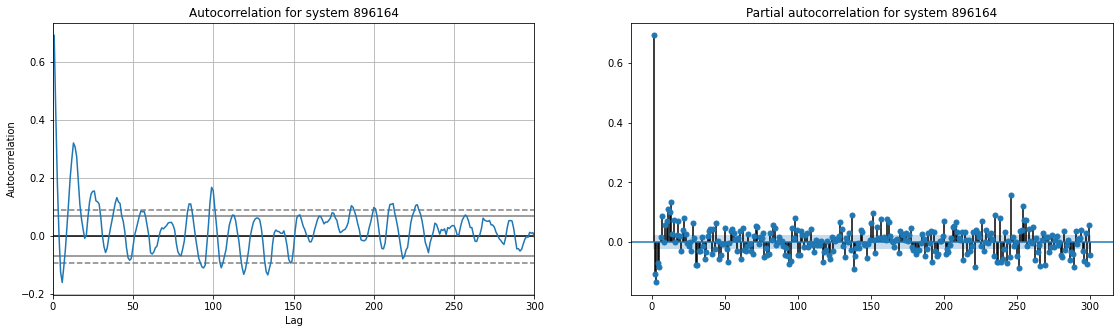

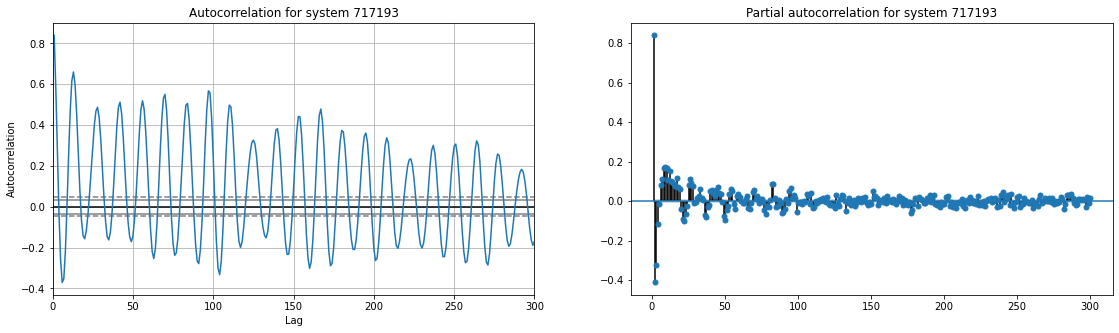

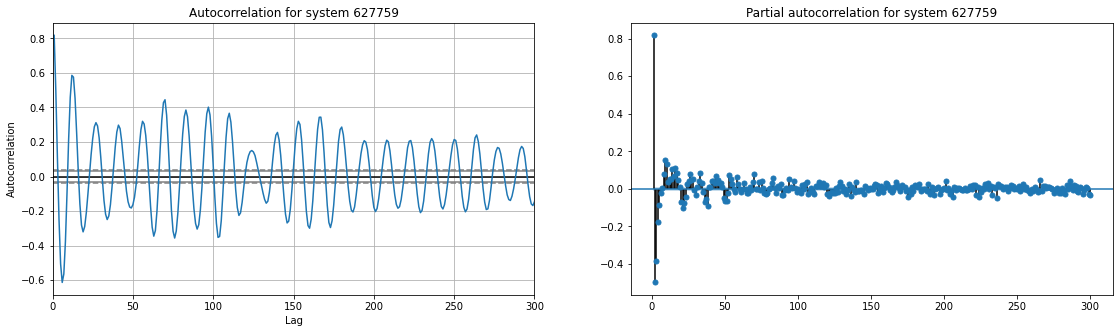

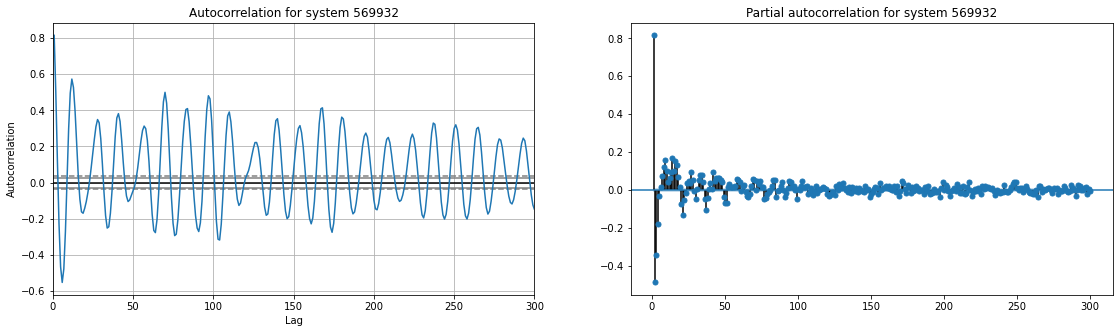

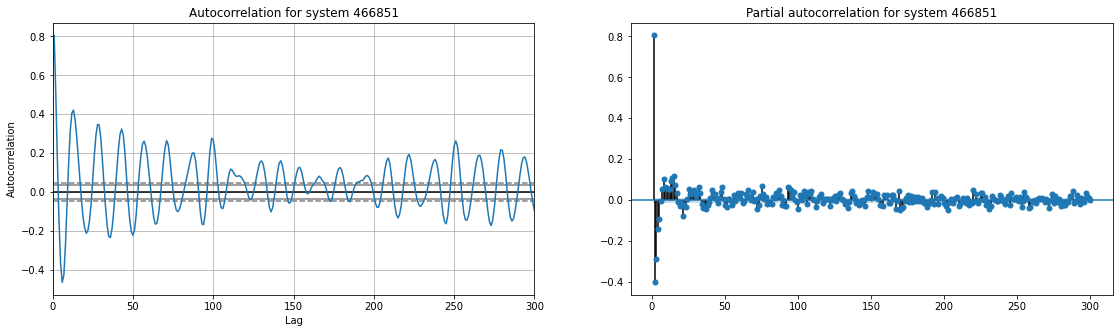

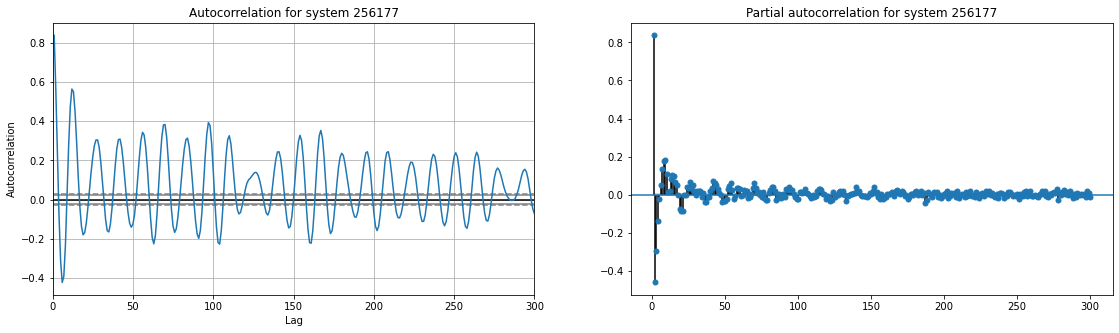

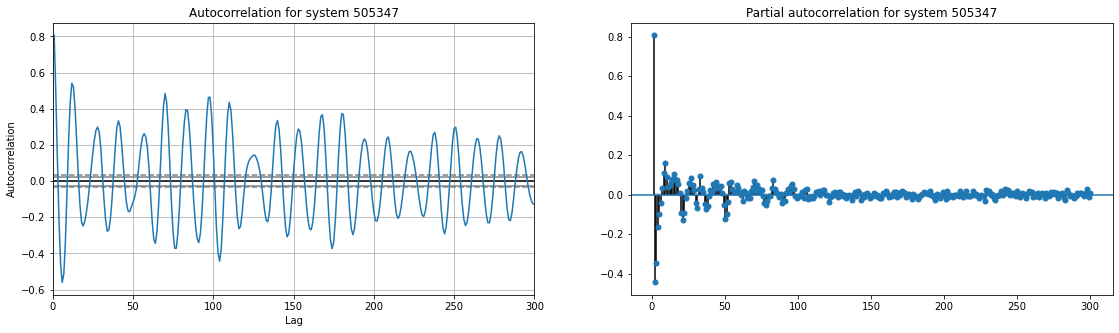

In [157]:
for site_id, df in dfs.items():
    plot_ac(df, 300, site_id)

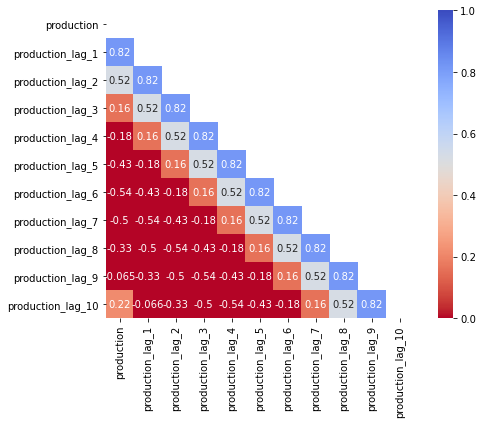

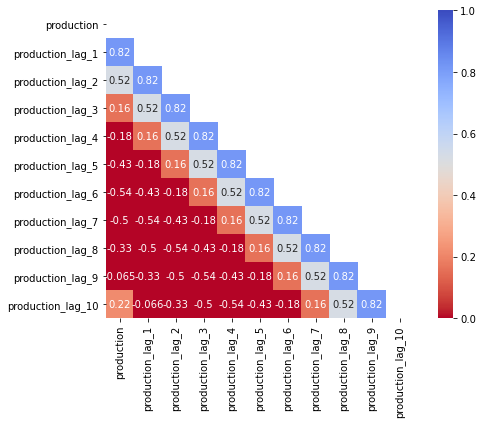

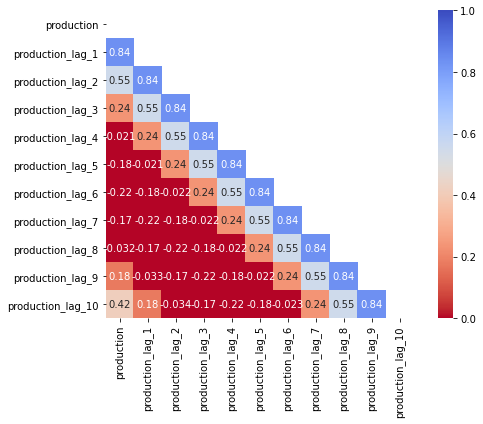

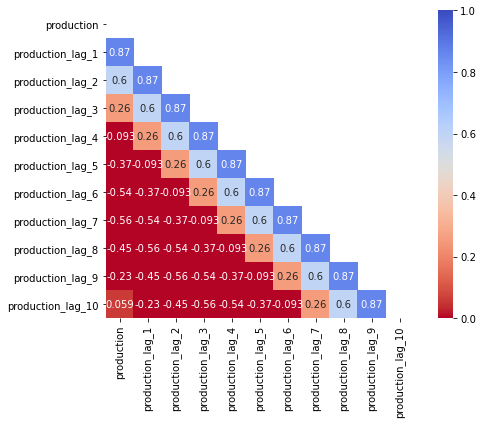

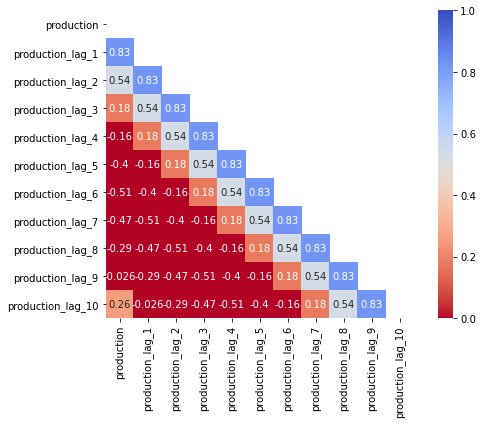

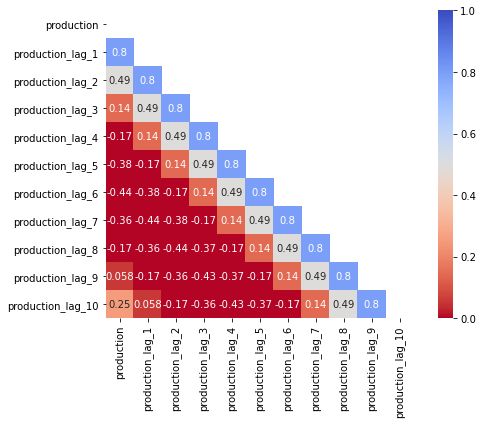

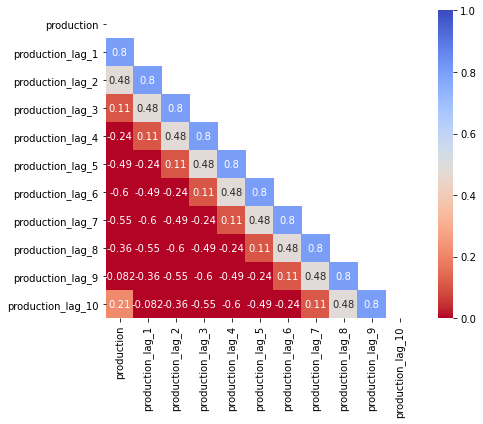

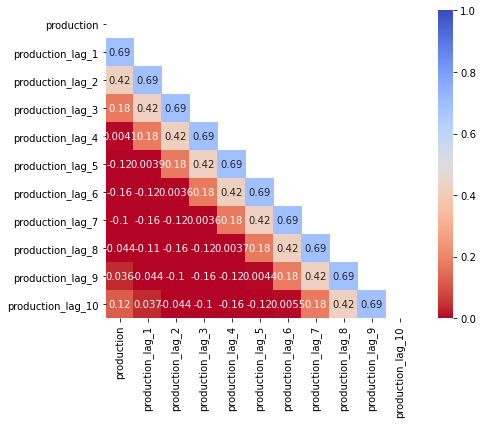

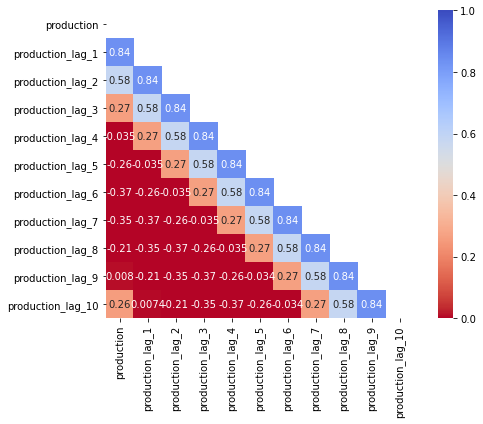

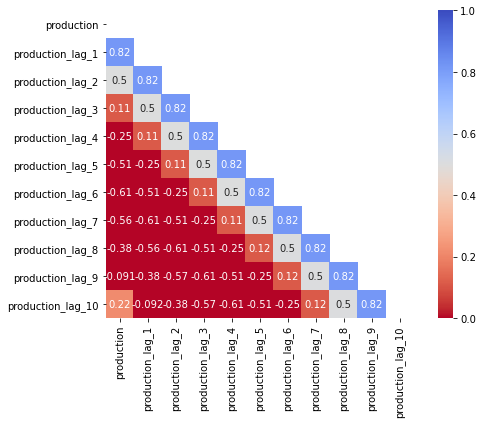

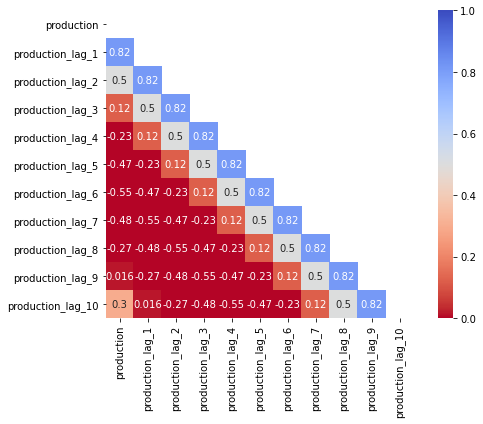

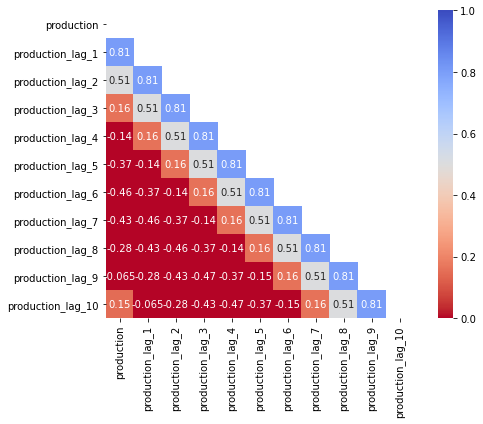

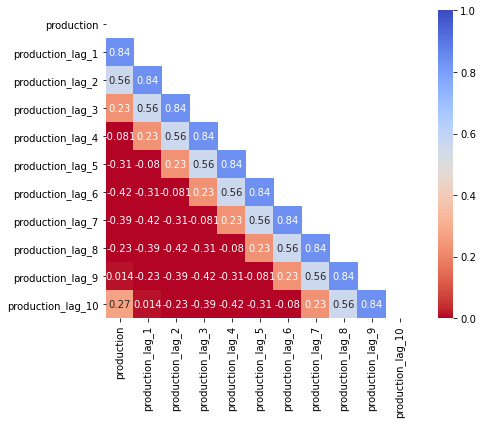

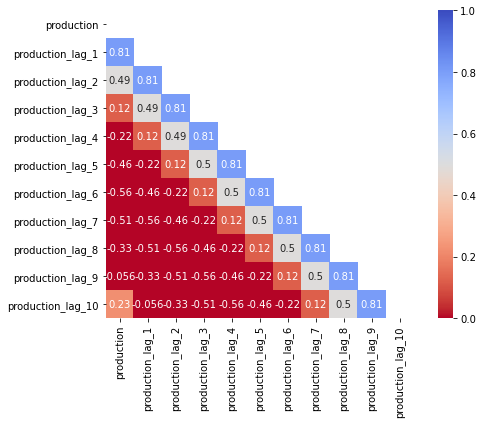

In [176]:
for site_id, df in dfs.items():
    plot_ac_heat(df, num_lags, site_id)

In [104]:
from sklearn.model_selection import TimeSeriesSplit

def train_test_splits(df):
    num_splits = 3
    s = TimeSeriesSplit(num_splits)
    df = df.reset_index()
    splits = []
    for train_index, test_index in s.split(df):
        print(train_index, test_index)        
        test, train = df.iloc[train_index], df.iloc[test_index]
        splits.append((test, train))
    return splits 

In [98]:
splits = train_test_split(df)
splits[0][1]

[   0    1    2 ... 4274 4275 4276] [4277 4278 4279 ... 8548 8549 8550]
[   0    1    2 ... 8548 8549 8550] [ 8551  8552  8553 ... 12822 12823 12824]
[    0     1     2 ... 12822 12823 12824] [12825 12826 12827 ... 17096 17097 17098]


date  Unnamed: 0    Year  Month   Day  Hour  Minute  \
4277 2016-01-26 17:00:00+00:00      1220.5  2016.0    1.0  26.0  10.0    15.0   
4278 2016-01-26 18:00:00+00:00      1222.5  2016.0    1.0  26.0  11.0    15.0   
4279 2016-01-26 19:00:00+00:00      1224.5  2016.0    1.0  26.0  12.0    15.0   
4280 2016-01-26 20:00:00+00:00      1226.5  2016.0    1.0  26.0  13.0    15.0   
4281 2016-01-26 21:00:00+00:00      1228.5  2016.0    1.0  26.0  14.0    15.0   
...                        ...         ...     ...    ...   ...   ...     ...   
8546 2017-01-09 23:00:00+00:00       416.5  2017.0    1.0   9.0  16.0    15.0   
8547 2017-01-10 00:00:00+00:00       418.5  2017.0    1.0   9.0  17.0    15.0   
8548 2017-01-10 15:00:00+00:00       448.5  2017.0    1.0  10.0   8.0    15.0   
8549 2017-01-10 16:00:00+00:00       450.5  2017.0    1.0  10.0   9.0    15.0   
8550 2017-01-10 17:00:00+00:00       452.5  2017.0    1.0  10.0  10.0    15.0   

       GHI   DHI  DNI  ...  cloudCover  uvIndex  visibility  ozone  \
4277   0.0   0.0  0.0  ...        0.00      1.0       9.997    NaN   
4278   0.0   0.0  0.0  ...        0.00      2.0       9.997    NaN   
4279   0.0   0.0  0.0  ...        0.00      3.0       9.997    NaN   
4280   0.0   0.0  0.0  ...        0.00      3.0       9.997    NaN   
4281   0.0   0.0  0.0  ...        0.00      3.0       9.997    NaN   
...    ...   ...  ...  ...         ...      ...         ...    ...   
8546  47.5  47.5  0.0  ...        0.75      0.0       9.997    NaN   
8547  89.0  89.0  0.0  ...        0.44      0.0       9.997    NaN   
8548   0.0   0.0  0.0  ...        0.00      0.0       9.997    NaN   
8549   0.0   0.0  0.0  ...        0.00      0.0       9.997    NaN   
8550   0.0   0.0  0.0  ...        0.00      1.0       9.997    NaN   

       production  production_lag_1 production_lag_2  production_lag_3  \
4277  1254.082300        724.971400        63.903600         106.91480   
4278  1602.200200       1254.082300       724.971400          63.90360   
4279  1733.453700       1602.200200      1254.082300         724.97140   
4280  1766.735700       1733.453700      1602.200200        1254.08230   
4281  1634.819200       1766.735700      1733.453700        1602.20020   
...           ...               ...              ...               ...   
8546   447.635600        703.793500       391.091700         168.61157   
8547    56.742040        447.635600       703.793500         391.09170   
8548    35.429745         56.742040       447.635600         703.79350   
8549   587.822400         35.429745        56.742040         447.63560   
8550   539.088300        587.822400        35.429745          56.74204   

      production_lag_4  production_lag_5  
4277         759.93884        1341.92100  
4278         106.91480         759.93884  
4279          63.90360         106.91480  
4280         724.97140          63.90360  
4281        1254.08230         724.97140  
...                ...               ...  
8546          81.29808          77.13106  
8547         168.61157          81.29808  
8548         391.09170         168.61157  
8549         703.79350         391.09170  
8550         447.63560         703.79350  

[4274 rows x 35 columns]

In [8]:
from os.path import exists

splits = {}

#Warning, this takes a while because the join operation is implemented inefficently (like n^2 in the worst case.)
for site in site_md:
    site_id = site['id']
    irradiance_site_id = site['irradiance_site_id']
    tz_str = site['location']['timeZone']
    
    path_production = f"{DATA_DIR}/production_data/{site_id}/combination_data/production_weather_combination.csv"
    path_irradiance = f"{DATA_DIR}/irradiance_data/{irradiance_site_id}/irradiance_data.csv"
    
    if not exists(path_irradiance):
        print(site_id,irradiance_site_id)
        continue
    
    X,Y,title_row = train_test_split.get_irradiance_WPI_data(path_production,path_irradiance, 4,3,tz_str)
    splits[site_id] = (X,Y)
    
    

1232644 116439


In [11]:
title_row

['day',
 'hour',
 'precipIntensity',
 'precipProbability',
 'precipAccumulation',
 'precipType_',
 'precipType_rain',
 'precipType_snow',
 'precipType_sleet',
 'temperature',
 'apparentTemperature',
 'dewPoint',
 'humidity',
 'pressure',
 'windSpeed',
 'windBearing',
 'windGust',
 'cloudCover',
 'uvIndex',
 'visibility',
 'ozone',
 'GHI',
 'DHI',
 'DNI']

Now that we have the rows as numpy vectors we want to create data frames for the test and train splits so that we use Pandas to feature engineer the lags to be used with the auto correlated values. 

In [13]:
import pandas as pd

splits_df = {}

([X_train,X_test],[Y_train,Y_test]) = splits[103941]
test_df = pd.DataFrame(data=X_train, columns=title_row)
test_df
# splits_df[103941] = {
    # 'train':
    # 'test': 
# }

day      hour  precipIntensity  precipProbability  \
0      1.337523  1.965926           0.0000               0.00   
1      1.337523  1.923880           0.0000               0.00   
2      1.337523  1.866025           0.0000               0.00   
3      1.337523  1.793353           0.0000               0.00   
4      1.337523  1.707107           0.0000               0.00   
...         ...       ...              ...                ...   
12824  1.008607  1.991445           0.0020               0.01   
12825  1.008607  1.965926           0.0000               0.00   
12826  1.008607  1.923880           0.0010               0.01   
12827  1.008607  1.866025           0.0000               0.00   
12828  1.008607  1.793353           0.0015               0.02   

       precipAccumulation  precipType_  precipType_rain  precipType_snow  \
0                     0.0          1.0              0.0              0.0   
1                     0.0          1.0              0.0              0.0   
2                     0.0          1.0              0.0              0.0   
3                     0.0          1.0              0.0              0.0   
4                     0.0          1.0              0.0              0.0   
...                   ...          ...              ...              ...   
12824                 0.0          0.0              1.0              0.0   
12825                 0.0          1.0              0.0              0.0   
12826                 0.0          0.0              1.0              0.0   
12827                 0.0          1.0              0.0              0.0   
12828                 0.0          0.0              1.0              0.0   

       precipType_sleet  temperature  ...  windSpeed  windBearing  windGust  \
0                   0.0        65.76  ...      10.85        218.0     22.36   
1                   0.0        66.65  ...      10.98        230.0     20.51   
2                   0.0        68.40  ...      11.05        250.0     21.61   
3                   0.0        66.97  ...       8.96        248.0     18.33   
4                   0.0        63.22  ...       7.68        253.0     17.00   
...                 ...          ...  ...        ...          ...       ...   
12824               0.0        41.74  ...       5.31        239.0      8.92   
12825               0.0        44.59  ...       7.66        268.0     11.54   
12826               0.0        45.26  ...       7.66        273.0     11.12   
12827               0.0        44.62  ...       7.21        256.0     10.40   
12828               0.0        39.69  ...       6.22        284.0      7.81   

       cloudCover  uvIndex  visibility  ozone    GHI   DHI    DNI  
0            0.00      4.0       9.997    0.0  618.5  68.0  977.5  
1            0.00      2.0       9.997    0.0  494.0  63.5  927.5  
2            0.00      1.0       9.997    0.0  321.5  54.5  825.5  
3            0.00      0.0       9.997    0.0  126.0  36.0  579.5  
4            0.00      0.0       9.997    0.0    0.0   0.0    0.0  
...           ...      ...         ...    ...    ...   ...    ...  
12824        0.05      3.0      10.000  295.3  529.5  51.5  983.0  
12825        0.07      2.0      10.000  299.1  458.0  50.0  951.5  
12826        0.06      1.0      10.000  303.3  333.0  47.0  877.0  
12827        0.04      0.0      10.000  308.1  110.0  54.5  289.0  
12828        0.02      0.0      10.000  316.9   15.5  11.5   67.5  

[12829 rows x 24 columns]